In [2]:
# importing the libraries
# basic stuff
import pandas as pd
import numpy as np
import math
import re
import nltk #swiss knife army for nlp
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from tqdm import tqdm
#from pymystem3 import Mystem

# nltk stemmers
stemmerRu = SnowballStemmer("russian") 
stemmerEn = PorterStemmer()
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering



In [3]:
#uploading data needed
df = pd.read_csv(r'/Users/apple/BDML/data/train.csv')
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
# preprocessing function
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    #lem_words=[Mystem().lemmatize(w) for w in filtered_words]
    #stem_words=[stemmerRu.stem(w) for w in filtered_words]
    return " ".join(filtered_words)


# cleaning text
#df['clean'] = df.map(lambda s:preprocess(s))
import langid
df['lang'] = df['text'].map(lambda s:langid.classify(s))
df = df[df['lang'].str.contains('ru', regex = False) == True]
df = df.drop(['lang'], axis = 1)
df.drop_duplicates(inplace=True)
df.index.is_unique
df.reset_index(drop=True, inplace=True)

In [5]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='text'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [5]:
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_df.txt', target='doc_id')

72300it [00:09, 7747.83it/s]


In [6]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_df.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batches2')

#batch_vectorizer = artm.BatchVectorizer(data_path='batches2', data_format='batches')


In [7]:
  # setting up dictionary
dictionary = batch_vectorizer.dictionary

In [8]:
number_of_topics = 60
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
#model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
#model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
#model_artm.scores.add(artm.TopTokensScore(name='Top_words', num_tokens=20, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [9]:
# fitting the model
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=16)

In [10]:
# phi and theta
artm_phi = model_artm.get_phi()
artm_theta = model_artm.get_theta()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
наличии - 0.012909069657325745
цена - 0.011983574368059635
руб - 0.006119051016867161
цвет - 0.005784705746918917
заказ - 0.005720832850784063
рублей - 0.005161155015230179
bmw - 0.0049072084948420525
цвета - 0.004467683378607035
дизайн - 0.004397090058773756
размер - 0.004029319155961275

 topic_1
срок - 0.00980234332382679
лет - 0.008937681093811989
доставка - 0.0069281188771128654
года - 0.005373135209083557
права - 0.0053078061901032925
дней - 0.004874332342296839
размере - 0.004782107658684254
суд - 0.004218425136059523
случае - 0.004044665955007076
рублей - 0.003941442351788282

 topic_2
день - 0.013270744122564793
сегодня - 0.010577140375971794
стоит - 0.005734456703066826
дня - 0.004672827664762735
постарайтесь - 0.00434265099465847
отношения - 0.004002585541456938
работа - 0.0034848323557525873
возможно - 0.0033620409667491913
дела - 0.0030827370937913656
здоровье - 0.0030361106619238853

 topic_3
делать - 0.006783962715417147
женщины - 0.005628973711282015
вопрос - 

человека - 0.0045618959702551365
имя - 0.004164506681263447
энергии - 0.0034970862325280905
деньги - 0.002753437263891101
жизни - 0.0027395966462790966
силы - 0.002402257639914751
свечи - 0.0023710662499070168
дом - 0.0022322642616927624
заговор - 0.002190323080867529
людей - 0.0021319082006812096

 topic_30
год - 0.01716664247214794
сша - 0.015172366984188557
мире - 0.004802495241165161
года - 0.004785776138305664
россия - 0.004726838320493698
италия - 0.004663020372390747
нью - 0.004584786482155323
франция - 0.00452918466180563
германия - 0.004258489236235619
остров - 0.0036763353273272514

 topic_31
люди - 0.012590733356773853
человека - 0.009135864675045013
люблю - 0.00907233264297247
жизни - 0.008537065237760544
людей - 0.007732006721198559
жизнь - 0.006986312102526426
рядом - 0.005410322919487953
хочется - 0.005133978556841612
лишь - 0.004405394196510315
значит - 0.0044041709043085575

 topic_32
день - 0.04530373215675354
праздник - 0.007290572393685579
года - 0.00608214689418673

новости - 0.008154134266078472
книги - 0.007493412587791681
запрещено - 0.005138247273862362
записки - 0.004605475813150406
интернет - 0.004553772509098053
дракон - 0.004299796186387539
правда - 0.0042042117565870285
лет - 0.003636967623606324
принцесса - 0.0034389146603643894
обо - 0.00343669974245131

 topic_57
счастья - 0.005323042627424002
любви - 0.005087409168481827
лишь - 0.004488060716539621
счастье - 0.004019829910248518
души - 0.003936526831239462
девочка - 0.003573287045583129
взгляд - 0.0030844949651509523
жизни - 0.0029887224081903696
тело - 0.0029683588072657585
страсти - 0.002952095353975892

 topic_58
подборка - 0.005951208062469959
обл - 0.004696168936789036
лошади - 0.0041925800032913685
монастырь - 0.0036650863476097584
лошадь - 0.0035822533536702394
факты - 0.003028427716344595
аниме - 0.002931521274149418
жизни - 0.0024093887768685818
хочу - 0.002085830084979534
жизнь - 0.0020255115814507008

 topic_59
человека - 0.00790504552423954
люди - 0.005880412179976702
люде

Text(0, 0.5, 'perplexity score')

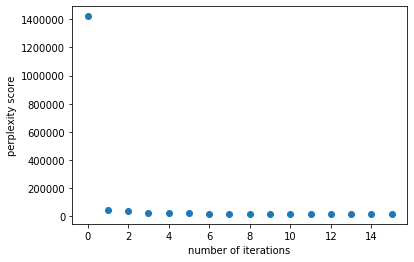

In [11]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)

%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity
plt.scatter(range(len(perplexityScore)), perplexityScore)
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [12]:
lables = dict()
for topic_name in model_artm.topic_names:
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:5])
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)

In [32]:
theta_transposed = artm_theta.transpose()

odd_themes = ['чтo этo кaк тaк мeня','человека люди людей именно часто',
              'люди жизнь человека сегодня жить','почему сегодня день делать знаю',
              'лет мама говорит дверь сказал','делать женщины вопрос женщина мужчины'
              
             ]
theta_transposed.drop(columns = odd_themes)


theta_transposed.to_csv('theta_transposed.csv')


#theta_transposed = pd.read_csv(r'theta_transposed.csv')

df['theme'] = theta_transposed.idxmax(axis=1)
df.head()

,doc_id,text,theme,_id
0,0,открыта вакансия составитель заявок рассмотрим...,работы тел дом требуется квартира,-171585368
1,1,неловкое чувство когдα боишься нαписαть челове...,люди человека люблю жизни людей,-171404269
2,2,нахуй нужна твоё отсутствие жизни делает люди ...,хочу лайк нахуй люблю блять,-171378742
3,3,хотите уходите привыкать брат дома бесuт скуча...,хочу лайк нахуй люблю блять,-171324398
4,4,представляете насколько весы нуждаются тепле л...,люди жизнь человека сегодня жить,-171288949


In [33]:
group_user = pd.read_csv(r'/Users/apple/BDML/data/group_user.csv')
lables = pd.read_csv(r'/Users/apple/BDML/data/train_ids.csv')
df = df.merge(lables, on = 'doc_id')
df.head()

,doc_id,text,theme,_id_x,_id_y
0,0,открыта вакансия составитель заявок рассмотрим...,работы тел дом требуется квартира,-171585368,-171585368
1,1,неловкое чувство когдα боишься нαписαть челове...,люди человека люблю жизни людей,-171404269,-171404269
2,2,нахуй нужна твоё отсутствие жизни делает люди ...,хочу лайк нахуй люблю блять,-171378742,-171378742
3,3,хотите уходите привыкать брат дома бесuт скуча...,хочу лайк нахуй люблю блять,-171324398,-171324398
4,4,представляете насколько весы нуждаются тепле л...,люди жизнь человека сегодня жить,-171288949,-171288949


In [34]:
df.theme.unique()

array(['работы тел дом требуется квартира',
       'люди человека люблю жизни людей', 'хочу лайк нахуй люблю блять',
       'люди жизнь человека сегодня жить',
       'люблю лишь сердце снова глаза',
       'компании года рублей году компания', 'чтo этo кaк тaк мeня',
       'почему сегодня день делать знаю', 'году века лет место города',
       'хочу любовь друг жизни знаю',
       'продам цена размер отдам состоянии',
       'iphone apple видео android новый',
       'области россии года районе города',
       'друзья сегодня группы день дорогие',
       'автомобиля работы производства система автомобиль',
       'день мышцы ноги упражнения упражнение',
       'хочу ищу пишите секс девушки', 'лет мама говорит дверь сказал',
       'наличии цена руб цвет заказ', 'amp альбом love рок группа',
       'игры матч футбол команды мира',
       'жанр фильм фильма режиссер драма', 'год сша мире года россия',
       'жизни жизнь любовь мир счастье',
       'делать женщины вопрос женщина мужчин

In [36]:
interests = group_user \
    .merge(df,left_on = 'group', right_on = '_id_x' ) \
    .drop(['text', 'doc_id'], axis = 1) \
    .sort_values('user')
interests = interests.reset_index()

In [37]:

interests = interests.pivot_table(index = 'user', columns='theme') \
    .replace(np.nan, 0) 

    

In [38]:
interests

_id_x                                   \
theme     amp альбом love рок группа iphone apple видео android новый   
user                                                                    
138                     0.000000e+00                     0.000000e+00   
175                     0.000000e+00                    -4.510653e+07   
176                     0.000000e+00                    -1.338874e+08   
200                    -3.507003e+07                     0.000000e+00   
252                     0.000000e+00                     0.000000e+00   
609                     0.000000e+00                     0.000000e+00   
713                     0.000000e+00                     0.000000e+00   
882                    -3.838377e+07                    -5.486442e+06   
936                     0.000000e+00                     0.000000e+00   
964                    -2.515376e+07                     0.000000e+00   
1112                    0.000000e+00                     0.000000e+00   
1139                    0.000000e+00                     0.000000e+00   
1221                    0.000000e+00                     0.000000e+00   
1301                    0.000000e+00                     0.000000e+00   
1483                   -2.515376e+07                     0.000000e+00   
1683                    0.000000e+00                     0.000000e+00   
1701                   -1.478456e+08                     0.000000e+00   
2023                    0.000000e+00                    -6.386040e+07   
2031                   -8.849749e+07                     0.000000e+00   
2076                    0.000000e+00                     0.000000e+00   
2124                    0.000000e+00                     0.000000e+00   
2158                    0.000000e+00                     0.000000e+00   
2214                   -2.637884e+07                     0.000000e+00   
2340                   -4.039542e+07                     0.000000e+00   
2352                    0.000000e+00                     0.000000e+00   
2376                   -3.960195e+07                     0.000000e+00   
2495                    0.000000e+00                     0.000000e+00   
2611                    0.000000e+00                     0.000000e+00   
2738                    0.000000e+00                     0.000000e+00   
2765                    0.000000e+00                     0.000000e+00   
...                              ...                              ...   
440144209               0.000000e+00                     0.000000e+00   
440153261               0.000000e+00                     0.000000e+00   
440184247               0.000000e+00                     0.000000e+00   
440366514               0.000000e+00                     0.000000e+00   
440496039               0.000000e+00                     0.000000e+00   
440591364               0.000000e+00                     0.000000e+00   
440928808               0.000000e+00                     0.000000e+00   
440976066               0.000000e+00                     0.000000e+00   
441102910               0.000000e+00                     0.000000e+00   
441120732              -1.478456e+08                     0.000000e+00   
441217423               0.000000e+00                     0.000000e+00   
441314164               0.000000e+00                     0.000000e+00   
441339414               0.000000e+00                     0.000000e+00   
441461003               0.000000e+00                     0.000000e+00   
441566330              -2.425494e+07                     0.000000e+00   
441579113               0.000000e+00                     0.000000e+00   
441764935               0.000000e+00                     0.000000e+00   
441873957               0.000000e+00                     0.000000e+00   
441933226               0.000000e+00                     0.000000e+00   
442401256               0.000000e+00                     0.000000e+00   
442574664               0.000000e+00                     0.000000e+00   
442847876       